Time Series Forecasting (Research Lab,2023)

Rossmann Store Sales Forecast 

Rossmann operates over 3,000 drugstores in 7 European countries. Currently, Rossmann store managers have to forecast their daily sales up to six weeks in advance. Store sales are influenced by many factors, such as promotions, competition, school and public holidays, seasonal and local conditions. Because thousands of store managers forecast sales based on their individual circumstances, the accuracy of results can vary widely. This booklet focuses primarily on time series analysis (seasonal decomposition, trends, autocorrelation).

Steps to be performed

1.Data pre-processing and cleaning                                                                                               
2.Visualize the data                                                                                                             
3.Make the time series data stationary, if required                                                                             
4.Plot correlation and auto-correlation charts                                                                                   
5.Selection of the parameters and building of model for the plotting                                                             
6.Use the model to make the required predictions 

In [1]:
#!pip install xgboost
#!pip install pmdarima

In [1]:
#!pip install fbprophet

In [3]:
# importing all the required libraries

#for data manipulation and calculations
import numpy as np
import pandas as pd
from datetime import datetime
from time import time

#for data plotting and visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
#matplotlib inline
import itertools
from scipy import stats

#for time series analysis
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# prophet by Facebook
#from fbprophet import Prophet
from prophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

Dataset

I have taken the dataset of Rossman Stores sales data from the Kaggle website. The dataset included 3 csv files, store.csv, train.csv and test.csv.
Using the train.csv and test.csv, the model can be trained to perform the required predictions. 
Additional store.csv is given to work upon the feature selection and to check whether the data is stationary or not.

Link for the dataset - https://www.kaggle.com/competitions/rossmann-store-sales/data

In [4]:
#importing training dataset

train = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/train.csv")
test = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/test.csv")
store = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/store.csv")

In [5]:
train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

EXPLORATORY DATA ANALYSIS (EDA) on the given dataset:

To perform data cleaning, data pre-processing, checking the sales trend that vary with different factors.

In [6]:
display(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
display(test.isnull().sum())

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [8]:
display(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [9]:
display(test[pd.isnull(test.Open)])

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [10]:
# replacing the null values with 1
test.fillna(1, inplace=True)

In [11]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [12]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

<AxesSubplot:title={'center':'Store1'}, xlabel='Date'>

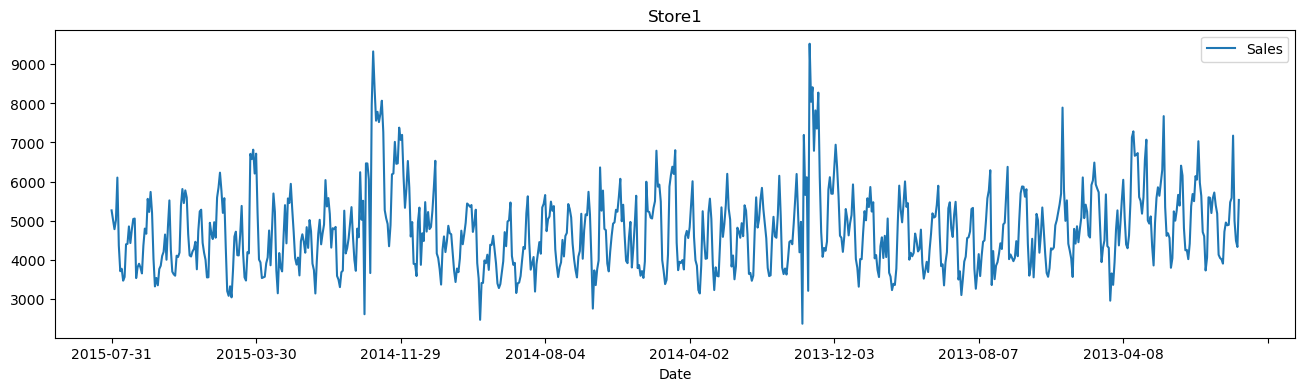

In [13]:
# sales of store1

strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

From the above chart, it is visible that the sales value for stores is achieving a peak during the month of December every year and there is a little spike during April and May. Both these duration, we can witness a jump in the sales as compared to other months.

Text(0.5, 1.0, 'Empirical Distribution of Sales')

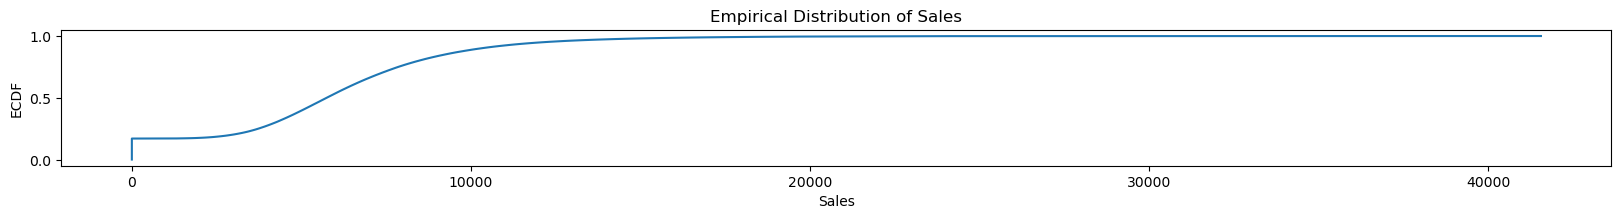

In [14]:
#as in above diagram it can be seen that data is not clearly distributed when plotted against the store data. Therefore the cummulative distribution fucntion is used to arrange the scale.

plt.figure(figsize = (20, 6))
plt.subplot(313)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Sales');
plt.ylabel('ECDF');
plt.title("Empirical Distribution of Sales")

In [15]:
# for working with the Sarima Model

train1 = train
train2 = pd.merge(train1, store, on='Store')   

# for working with the Xgboost model

df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

In [16]:
#combining the two features to create a new feature that describes average sales per customer

train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2.shape

(1017209, 19)

In [17]:
def features_create(data):
    
    data['Date'] = pd.to_datetime(data['Date'])

    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [18]:
features_create(df_train_store)
features_create(df_test_store)
features_create(train2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5,2013-01-05,4771,339,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.073746,2013,1,5,1,24157.0,6.75,Jan,0
1017205,1115,4,2013-01-04,4540,326,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",13.926380,2013,1,4,1,24157.0,6.75,Jan,0
1017206,1115,3,2013-01-03,4297,300,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.323333,2013,1,3,1,24157.0,6.75,Jan,0
1017207,1115,2,2013-01-02,3697,305,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",12.121311,2013,1,2,1,24157.0,6.75,Jan,0


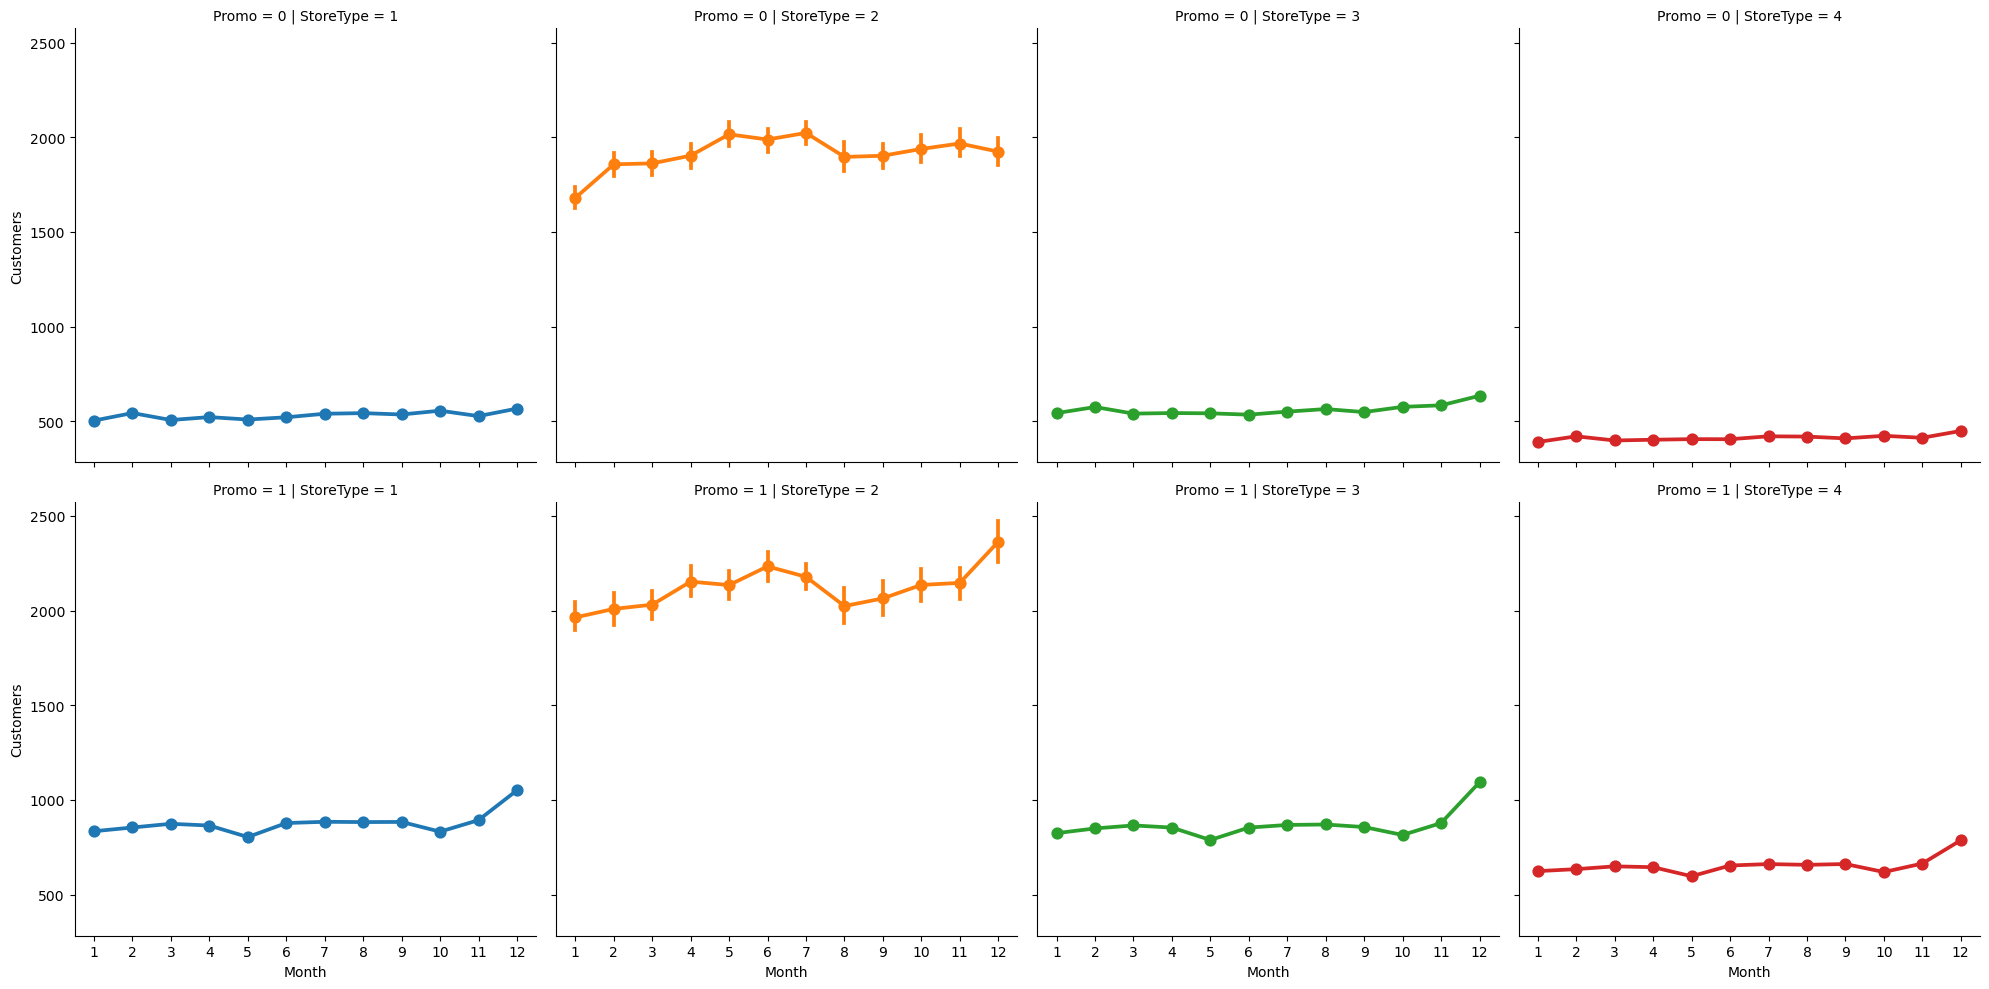

In [19]:
#customer trends against month

sns.factorplot(data = train2, x = 'Month', y = "Customers", 
col = 'StoreType', #for different store types
hue = 'StoreType',
row = 'Promo', #for different promos
) 

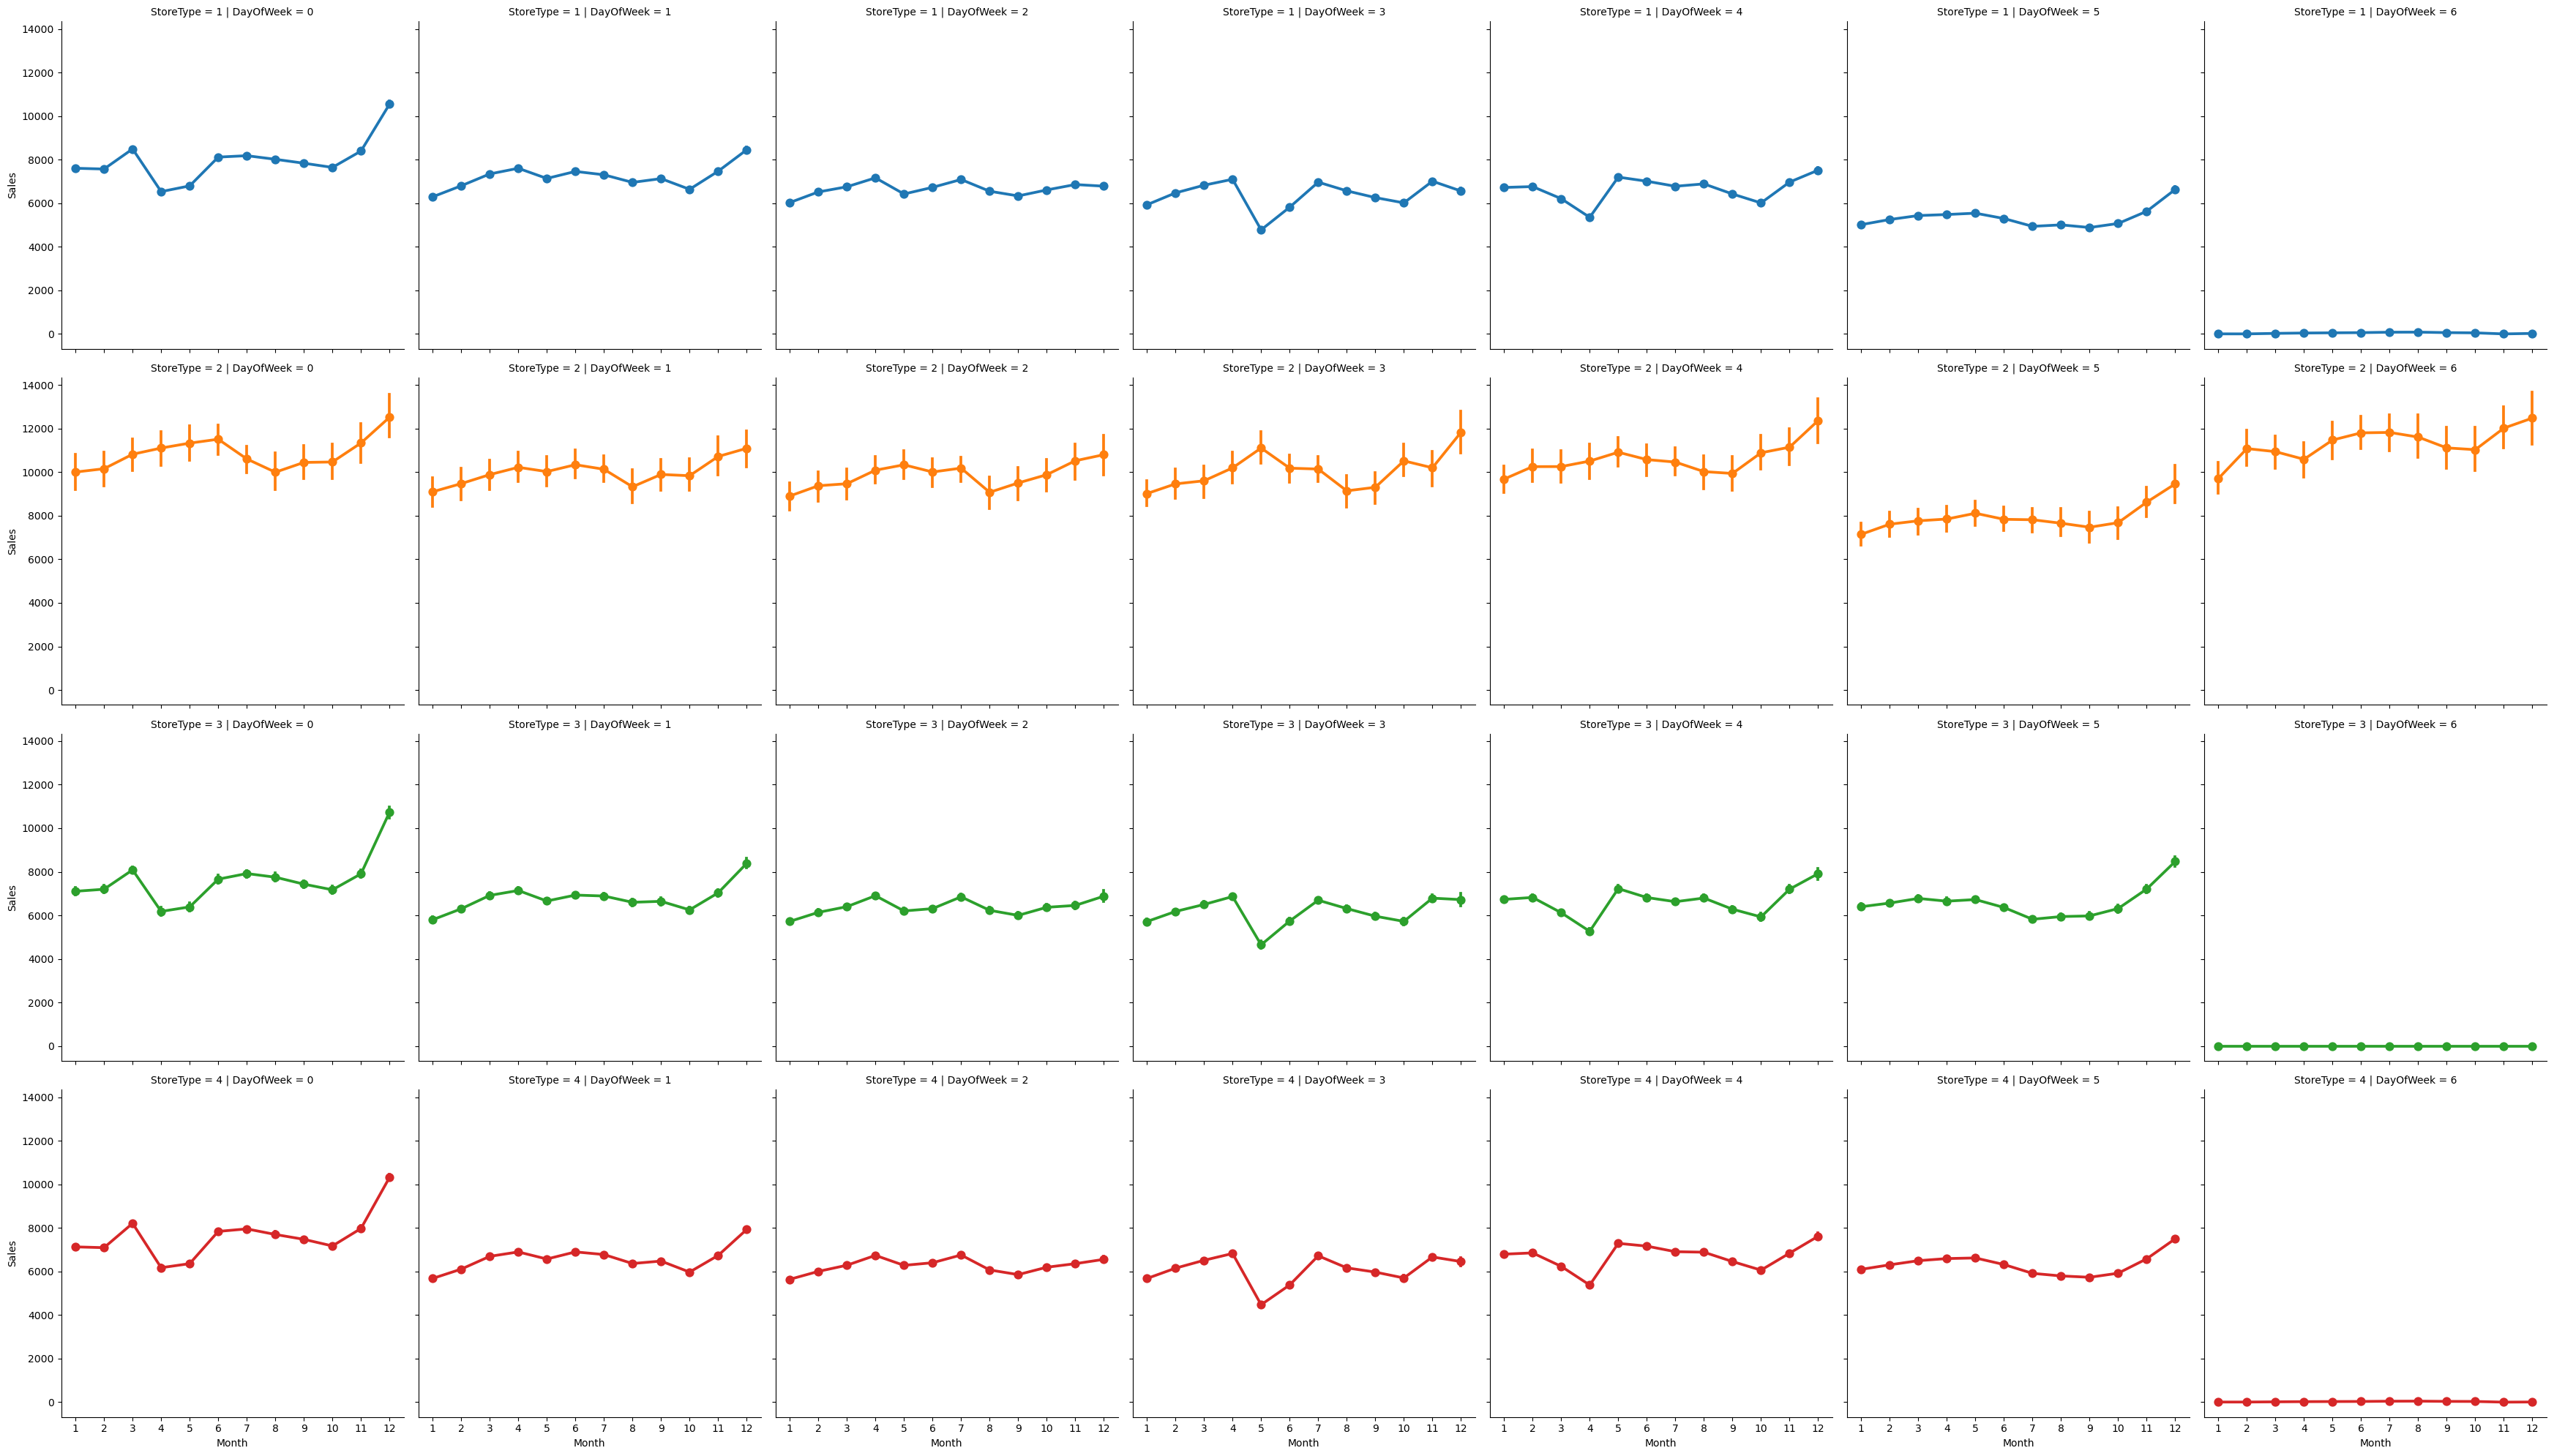

In [20]:
#sales plot for the different days of week and for different store types.

sns.factorplot(data = train2, x = 'Month', y = "Sales", 
col = 'DayOfWeek', #for different store types
hue = 'StoreType',
row = 'StoreType', #for different promos
) 

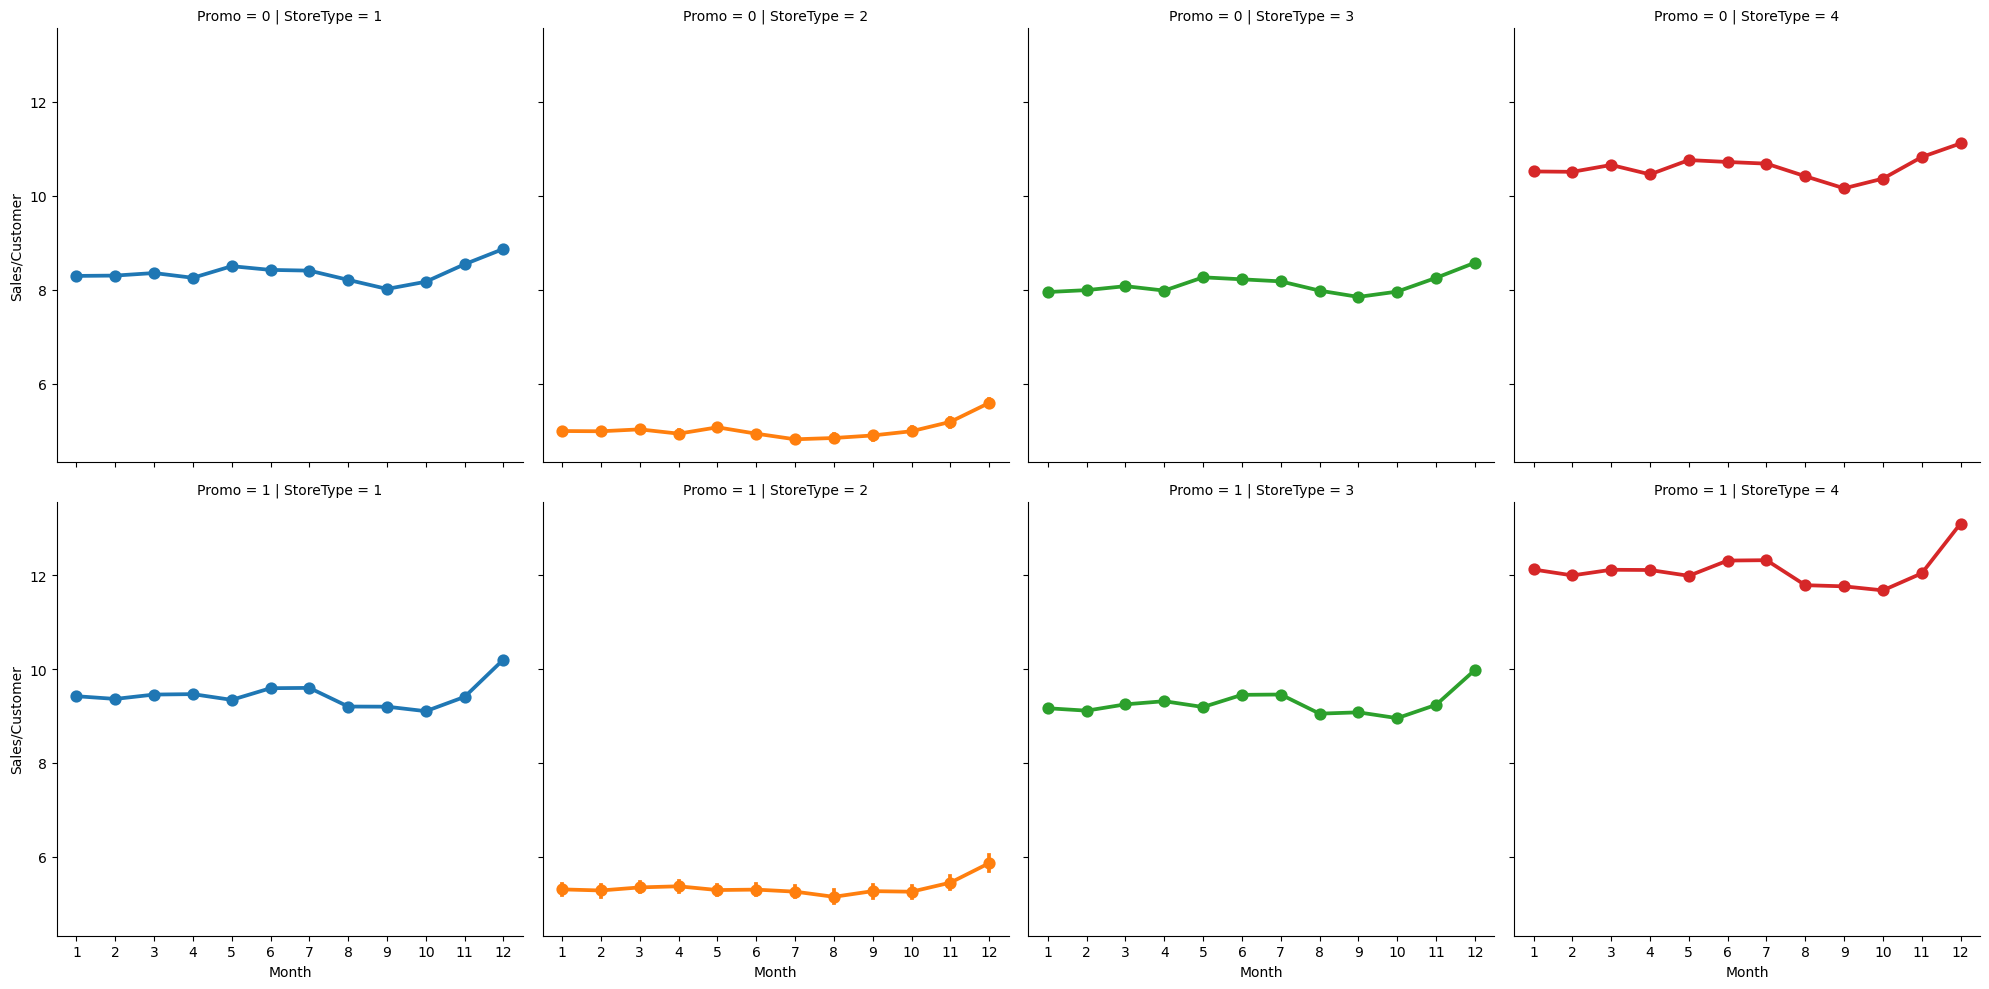

In [21]:
#sales/customer trend against month

sns.factorplot(data = train2, x = 'Month', y = "Sales/Customer", 
col = 'StoreType', #for different store types
hue = 'StoreType',
row = 'Promo', #for different promos
) 

<AxesSubplot:>

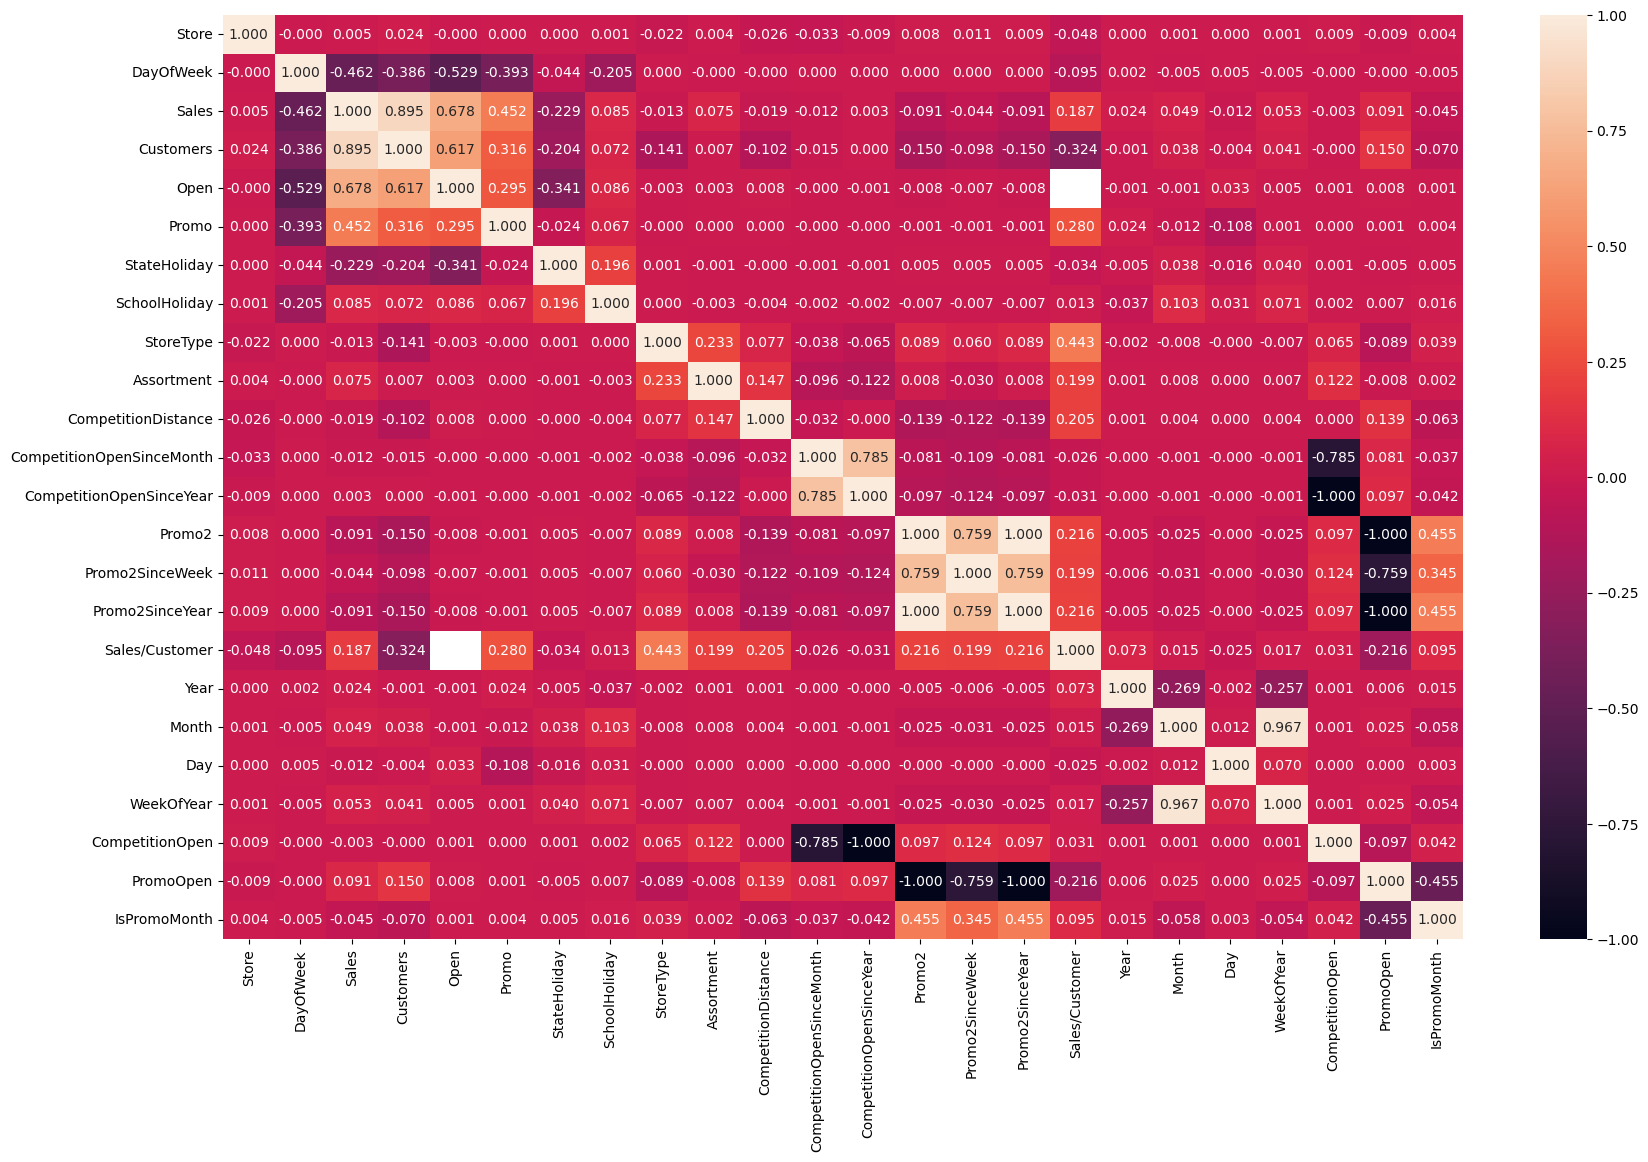

In [22]:
plt.figure(figsize = (20,12))

sns.heatmap(train2.corr(),annot = True, fmt = '.3f',vmin = -1,vmax = 1)

Now we are done with the feature creation process and by displaying the heat map we can say that customers, promo, open and sales/customer are highly correlated with the sales of the stores.

Conclusion of the Exploratory Data Analysis:

1. The StoreType A has the most sales and customers value, indicating that these type of stores are the most selling and crowded.                                                                                                                         
2. The StoreType D has the maximum Sales/Customer value. This suggests that, people make large amount of bills at these stores.
3. On the other hand, even though the store type B has great sales and customer trends, but it has least value for the Sales/Customer. This may be because, the people come to these store more often, because of which their trend is higher individually, but they might not purchase is higher amounts, because of which the average value is less.
4. We can also see that for all the type of stores, highest selling is done on the first day of the week;. on Monday.
5. Store Type B shows great selling even on Sundays. However, other store types remains closed on Sunday.

Model Training for the Time Series Analysis -

Checking for the data trends, seasonalities and auto-correlation.
To check this, we will work on 4 different stores from each store type, in order to find out their data trends, seasonal trends, etc.
We will select the following store for each type-

For StoreType A, we take Store == 2.                                                                                             
For StoreType B, we take Store == 85.                                                                                           
For StoreType C, we take Store == 1.                                                                                             
For StoreType D, we take Store == 13.

In [23]:
train2 = train2.set_index('Date')

In [24]:
train2.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,3,1,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
2015-07-30,1,3,5020,546,1,1,0,1,3,1,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2015-07-29,1,2,4782,523,1,1,0,1,3,1,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
2015-07-28,1,1,5011,560,1,1,0,1,3,1,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
2015-07-27,1,0,6102,612,1,1,0,1,3,1,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0


In [25]:
train2['Sales'] = train2['Sales'] * 1.0

sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales']
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

sales_a.head()

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Date'>

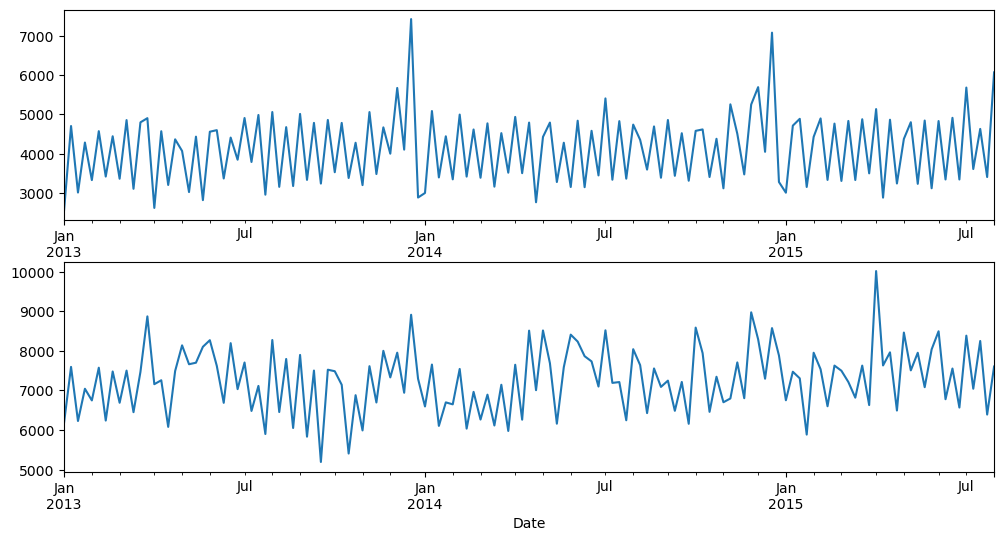

In [69]:
#f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
f, (ax1, ax2) = plt.subplots(2, figsize = (12, 6))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').mean().plot(ax = ax2)
#sales_c.resample('W').sum().plot(ax = ax3)
#sales_d.resample('W').sum().plot(ax = ax4)

We can see the above graphs of the stores clubbed together on the basis of the store type.
StoreType A and C shows a peak in sales during the Christmas season.
StoreType B shows peak during Christmas and Easter too. The sales graph for StoreType D is stable most of the time, some peak is there during Christmas, but there is also no data available during the period of July 2014 to Dec 2014, as the store was closed.

Stationarize the data:

In a linear regression, the assumption is that the observations are dependent on each other. However in time series, the observations are dependent on time. Some of the trends hold their properties for the independent variables if there is stationarity in the data. Hence by making our data stationary, we can apply the time series to it.

For checking whether our data is stationary or not, we can make use of a method called Dickey Fuller Test.

If the ‘Test Statistic’ is less than the ‘Critical Value’ than the time series is stationary.
Also, if the p-value is less than the significance value (0.05), we can say that our data is stationary.

In [27]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(18, 8))
    orig = plt.plot(sales_a.resample('W').mean(),color='blue',label='original')
    roll_mean = plt.plot(rolmean.resample('W').mean(),color='red',label='rolling mean')
    orig_std = plt.plot(rolstd.resample('W').mean(),color='green',label=' rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


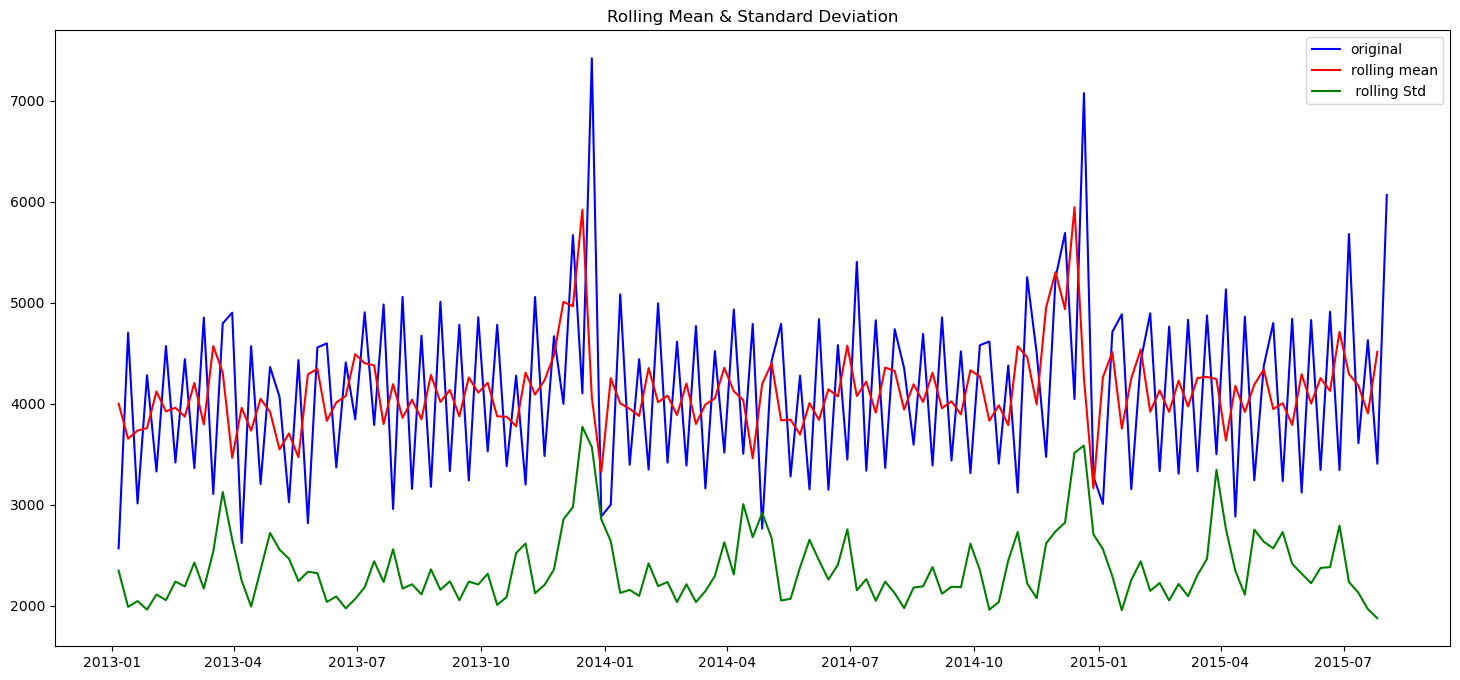

In [28]:
test_stationarity(sales_a)

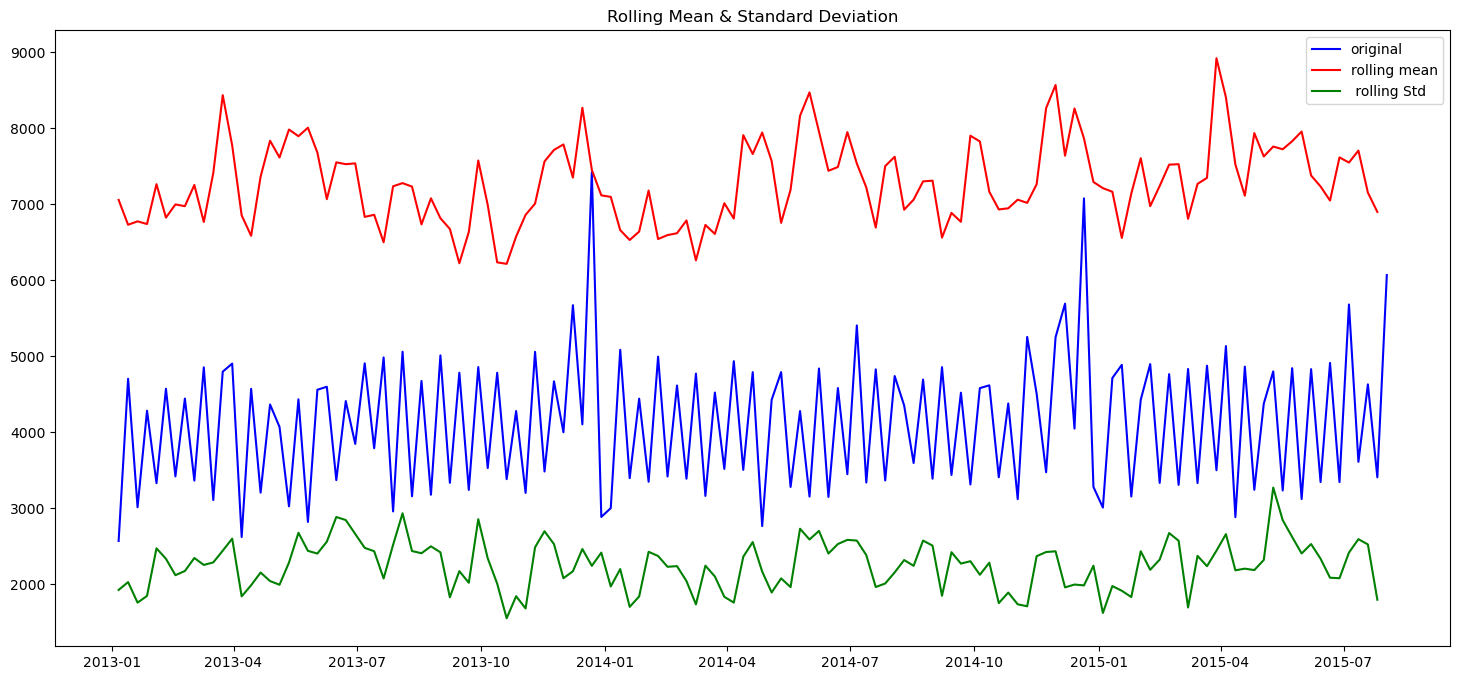

In [29]:
test_stationarity(sales_b)

In [30]:
#test_stationarity(sales_c)

In [31]:
#test_stationarity(sales_d)

In [32]:
#Performing Dickey Fuller test to check whether test statistics value is less than critical value or not
from statsmodels.tsa.stattools import adfuller
def stationary_check(sales):
  result = adfuller(sales,autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	   print(key, value)


In [33]:
print("Dickey Fuller test for store type A:")
stationary_check(sales_a)
print("Dickey Fuller test for store type B:")
stationary_check(sales_b)
print("Dickey Fuller test for store type C:")
stationary_check(sales_c)
print("Dickey Fuller test for store type D:")
stationary_check(sales_d)

Dickey Fuller test for store type A:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
Dickey Fuller test for store type B:
ADF Statistic: -5.589202
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459
Dickey Fuller test for store type C:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
Dickey Fuller test for store type D:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


Now plotting the Decomposition plots to check for the seasonal trends of each store type

In [34]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    if (StoreType == 'a') or (StoreType == 'b') or (StoreType == 'c'):
        decomposition= seasonal_decompose(sales, model = 'additive',period=360)
    elif (StoreType == 'd'):
        decomposition= seasonal_decompose(sales, model = 'additive',period=310)


    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    plt.title('Decomposition for StoreType')

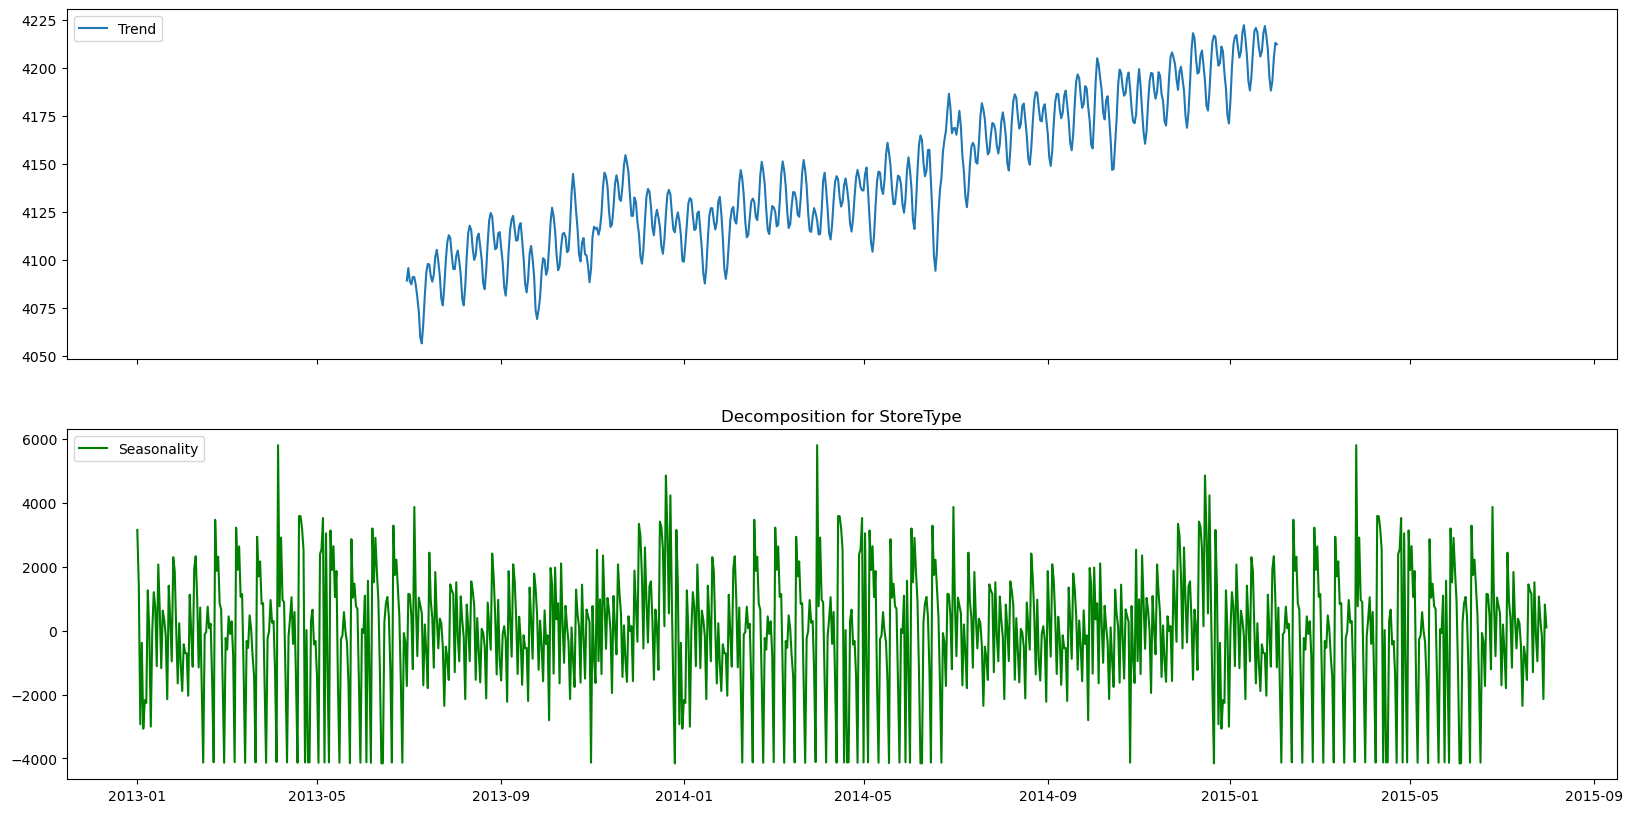

In [35]:
plot_timeseries(sales_a,'a')

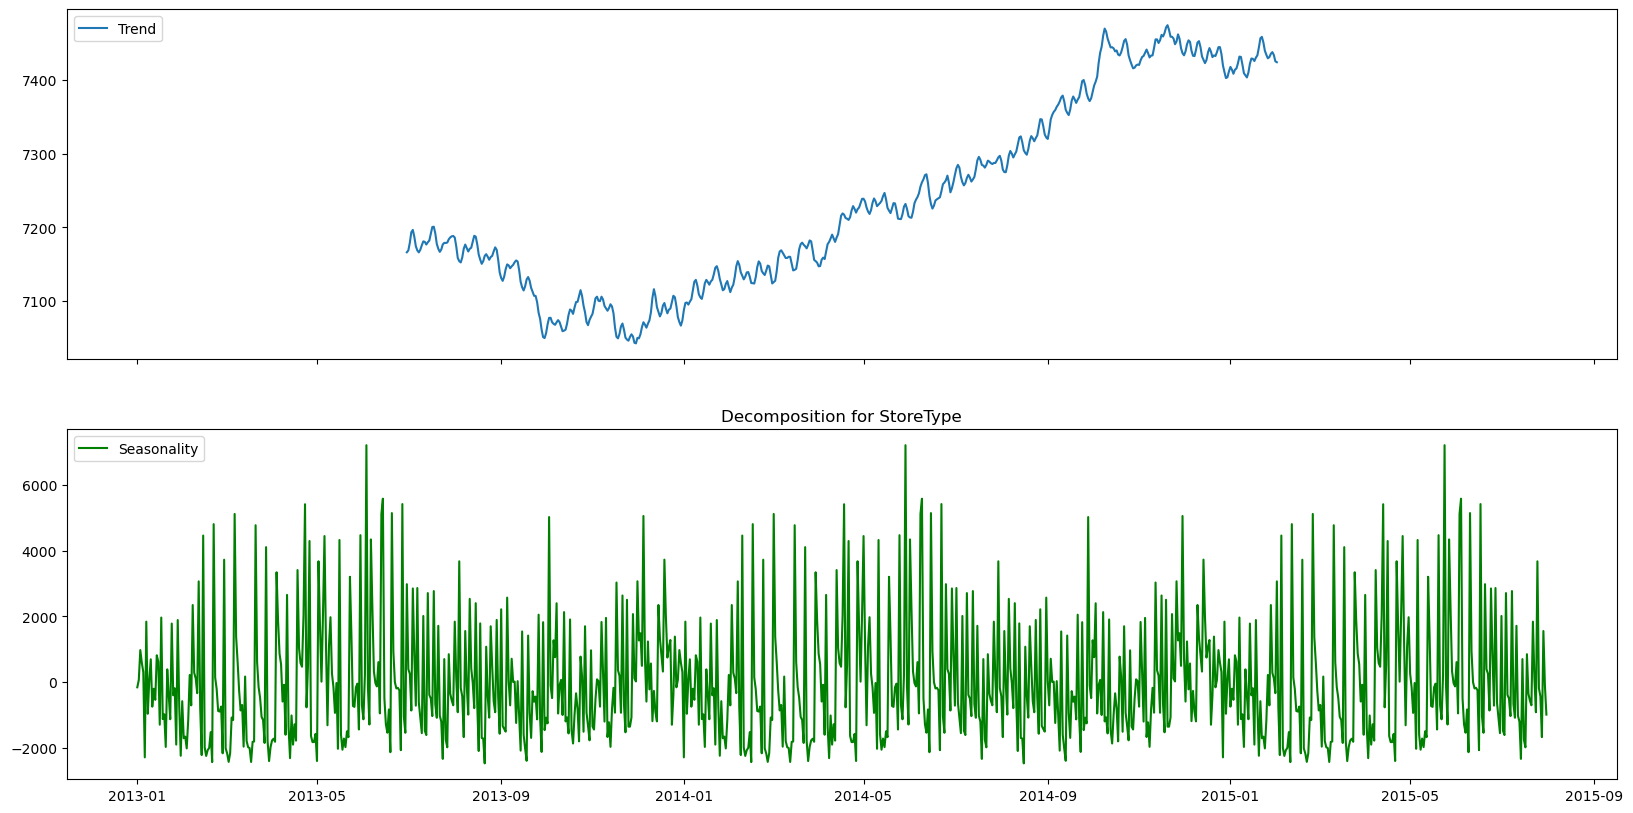

In [36]:
plot_timeseries(sales_b,'b')

In [37]:
#plot_timeseries(sales_c,'c')

In [38]:
#plot_timeseries(sales_d,'d')

The sales trend can be seen in increasing manner overall, only except for StoreType C. It has a downward trend.

Autocorrelation : Autocorrelation, sometimes referred to as serial correlation or cross-autocorrelation, is the cross-correlation of a signal with itself at different periods in time. It is the correlation between the values of the process at different times in time. It's the comparability of observations with regard to their temporal lag, to put it technically. Mathematicians utilize this technique to find recurrent patterns, such as the existence of a periodic signal masked by noise.

The next phase of our time series investigation involves reviewing the autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs.

Autocorrelation Function (ACF) : ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

Partial Autocorrelation Function (PACF) : PACF measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [39]:
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=30,method='ols')
  
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.title('ACF')


    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.title('PACF')

    print(lag_pacf)

[ 1.          0.20651915 -0.09576743 -0.19100379 -0.22521026 -0.13186546
 -0.02449702  0.50544718 -0.42497192 -0.29808104 -0.20679747  0.05834723
 -0.00724741  0.08243399  0.47175395 -0.15515769 -0.11202239 -0.08201511
 -0.01543917  0.01507114 -0.01738487  0.18586872 -0.07168663  0.02395544
 -0.03086245  0.00120317 -0.01280194 -0.01594368  0.32038124 -0.11495123
 -0.01932056]


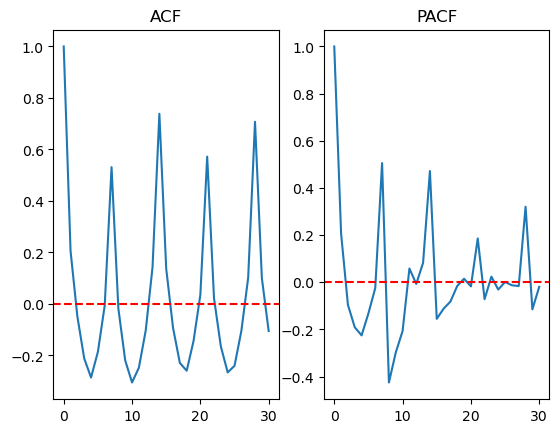

In [40]:
auto_corr(sales_a)

In [41]:
#auto_corr(sales_b)

In [42]:
#auto_corr(sales_c)

In [43]:
#auto_corr(sales_d)

In [44]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)


In [60]:
#print(pdq,seasonal_pdq)

In [46]:
def sample(sales):
  return(sales.resample('MS').mean())

In [47]:
y_sale_a = sample(sales_a)
y_sale_b = sample(sales_b)
y_sale_c = sample(sales_c)
y_sale_d = sample(sales_d)

In [48]:
def model(i,sale):
  ex = train2.loc[train2['Store'] == i,['Customers','Promo']]
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [49]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [50]:
#y_sale_model_a

In [51]:
exog_a = exog_a.dropna()
exog_a.isna().sum()

exog_b = exog_b.dropna()
exog_b.isna().sum()

exog_c = exog_c.dropna()
exog_c.isna().sum()

exog_d = exog_d.dropna()
exog_d.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

In [52]:
def predictions(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,exog,order=or1,seasonal_order=sord,enforce_stationarity=False,enforce_invertibility=False)

    results = mod.fit(disp=0)
    ## -----------------------predictions-------------------
    pred_sales = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_sales_ci = pred_sales.conf_int()
    
    ##------------------------plot-----------------------------
    ax = y_sale['2013':].plot(label='Observed')
    pred_sales.predicted_mean.plot(ax=ax, label='Predicted', alpha=1)

    ax.fill_between(pred_sales_ci.index,
                      pred_sales_ci.iloc[:, 1],
                      pred_sales_ci.iloc[:, 1], alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.legend()

    plt.show()
    

    y_forecasted = pred_sales.predicted_mean
    print(y_forecasted)
    y_truth = y_sale['2015-01-01':'2015-07-01']
    print("ye hai org",y_truth)

   ##-------------Compute the mean square error----------------
    mse = np.mean((y_truth - y_forecasted)**2)
    rmse = np.sqrt(mse)
    rmspe =  np.sqrt(np.mean(((y_truth-y_forecasted)/y_truth)**2))*100
    return results , mse,rmse,rmspe

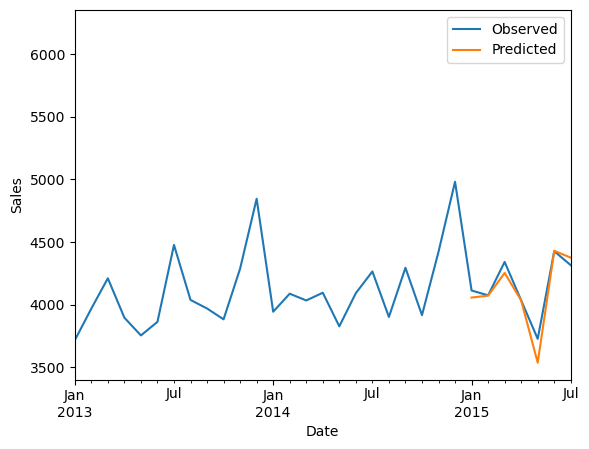

Date
2015-01-01    4056.433014
2015-02-01    4072.163840
2015-03-01    4253.079097
2015-04-01    4033.754787
2015-05-01    3536.277847
2015-06-01    4430.132468
2015-07-01    4375.070051
Freq: MS, Name: predicted_mean, dtype: float64
ye hai org Date
2015-01-01    4112.838710
2015-02-01    4074.214286
2015-03-01    4341.096774
2015-04-01    4033.733333
2015-05-01    3726.935484
2015-06-01    4426.666667
2015-07-01    4315.000000
Freq: MS, Name: Sales, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                   0.000
Date:                            Sun, 10 Sep 2023   AIC                             24.000
Time:                                    16:17:03   BIC                                nan
Sample:                                01-01-2013   HQIC                   

In [53]:
#Store Type A - example 1

or_a = (2,1,2)
sord_a=(2,1,2,12)
result_a,mse_a,rmse_a,rmspe_a= predictions(y_sale_model_a,exog_a,or_a,sord_a)
print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Mean Squared Per Error of our forecasts is {}'.format(round(rmspe_a, 2)))

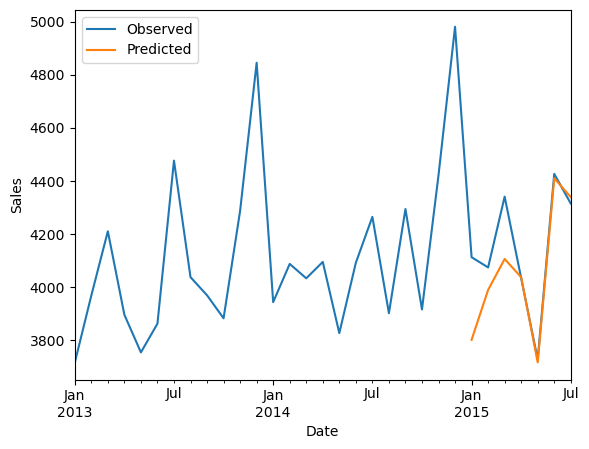

Date
2015-01-01    3801.307523
2015-02-01    3989.574153
2015-03-01    4106.049170
2015-04-01    4037.312692
2015-05-01    3716.501906
2015-06-01    4410.222923
2015-07-01    4339.293095
Freq: MS, Name: predicted_mean, dtype: float64
ye hai org Date
2015-01-01    4112.838710
2015-02-01    4074.214286
2015-03-01    4341.096774
2015-04-01    4033.733333
2015-05-01    3726.935484
2015-06-01    4426.666667
2015-07-01    4315.000000
Freq: MS, Name: Sales, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -18.265
Date:                            Sun, 10 Sep 2023   AIC                             50.530
Time:                                    16:17:04   BIC                             46.234
Sample:                                01-01-2013   HQIC                   

In [54]:
#Store Type A - example 2

or_a = (1,1,1)
sord_a=(0, 1, 1, 12)
result_a,mse_a,rmse_a,rmspe_a= predictions(y_sale_model_a,exog_a,or_a,sord_a)
print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Mean Squared Per Error of our forecasts is {}'.format(round(rmspe_a, 2)))

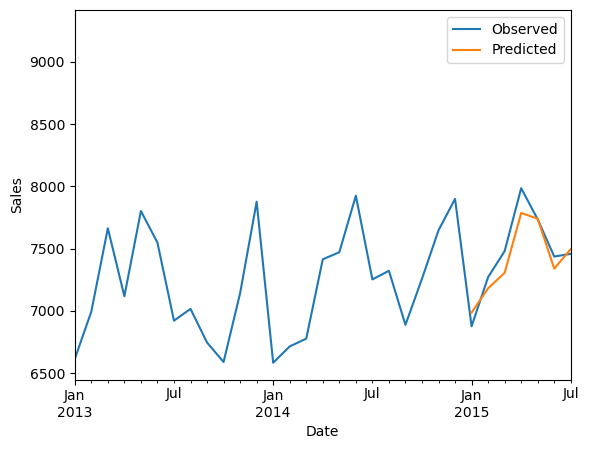

Date
2015-01-01    6985.641289
2015-02-01    7180.582324
2015-03-01    7304.756911
2015-04-01    7785.329608
2015-05-01    7739.012105
2015-06-01    7338.109538
2015-07-01    7495.559678
Freq: MS, Name: predicted_mean, dtype: float64
ye hai org Date
2015-01-01    6875.741935
2015-02-01    7270.357143
2015-03-01    7479.161290
2015-04-01    7984.066667
2015-05-01    7733.870968
2015-06-01    7435.466667
2015-07-01    7457.290323
Freq: MS, Name: Sales, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                   0.000
Date:                            Sun, 10 Sep 2023   AIC                             24.000
Time:                                    16:17:04   BIC                                nan
Sample:                                01-01-2013   HQIC                   

In [55]:
#Store Type B - example 1

or_b = (2,1,2)
sord_b=(2, 1, 2, 12)
result_b,mse_b,rmse_b,rmspe_b= predictions(y_sale_model_b,exog_b,or_b,sord_b)
print(result_b.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_b, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_b, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_b, 2)))

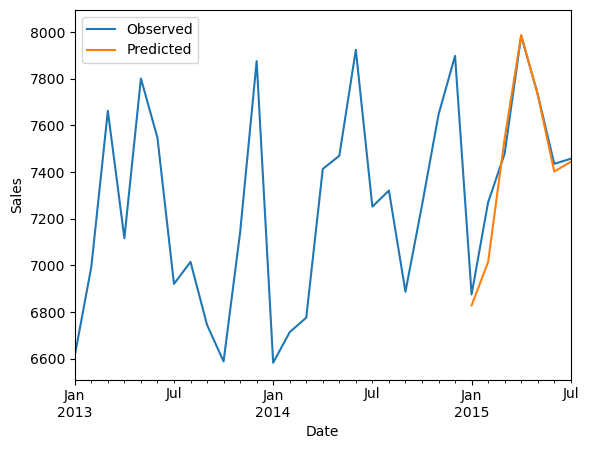

Date
2015-01-01    6828.677474
2015-02-01    7014.628031
2015-03-01    7543.589040
2015-04-01    7987.530640
2015-05-01    7732.006206
2015-06-01    7402.437482
2015-07-01    7444.222442
Freq: MS, Name: predicted_mean, dtype: float64
ye hai org Date
2015-01-01    6875.741935
2015-02-01    7270.357143
2015-03-01    7479.161290
2015-04-01    7984.066667
2015-05-01    7733.870968
2015-06-01    7435.466667
2015-07-01    7457.290323
Freq: MS, Name: Sales, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -17.212
Date:                            Sun, 10 Sep 2023   AIC                             48.424
Time:                                    16:17:06   BIC                             44.128
Sample:                                01-01-2013   HQIC                   

In [56]:
#Store Type B - example 2

or_b = (1,1,1)
sord_b=(0, 1, 1, 12)
result_b,mse_b,rmse_b,rmspe_b= predictions(y_sale_model_b,exog_b,or_b,sord_b)
print(result_b.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_b, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_b, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_b, 2)))

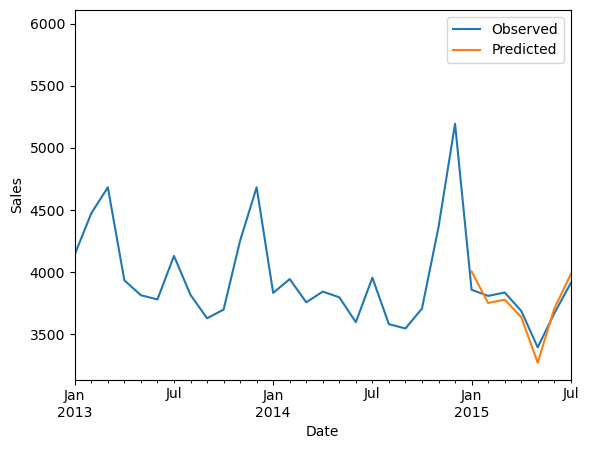

Date
2015-01-01    4005.612605
2015-02-01    3751.578757
2015-03-01    3778.052354
2015-04-01    3638.885097
2015-05-01    3270.605687
2015-06-01    3705.282569
2015-07-01    3983.327100
Freq: MS, Name: predicted_mean, dtype: float64
ye hai org Date
2015-01-01    3858.129032
2015-02-01    3808.392857
2015-03-01    3836.032258
2015-04-01    3688.500000
2015-05-01    3394.193548
2015-06-01    3667.033333
2015-07-01    3911.806452
Freq: MS, Name: Sales, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(3, 1, 3)x(3, 0, 3, 12)   Log Likelihood                   0.000
Date:                            Sun, 10 Sep 2023   AIC                             32.000
Time:                                    16:17:06   BIC                                nan
Sample:                                01-01-2013   HQIC                   

In [57]:
#Store Type C - example 1

or_c = (3,1,3)
sord_c=(3,0,3,12)
result_c,mse_c,rmse_c,rmspe_c= predictions(y_sale_model_c,exog_c,or_c,sord_c)
print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_c, 2)))

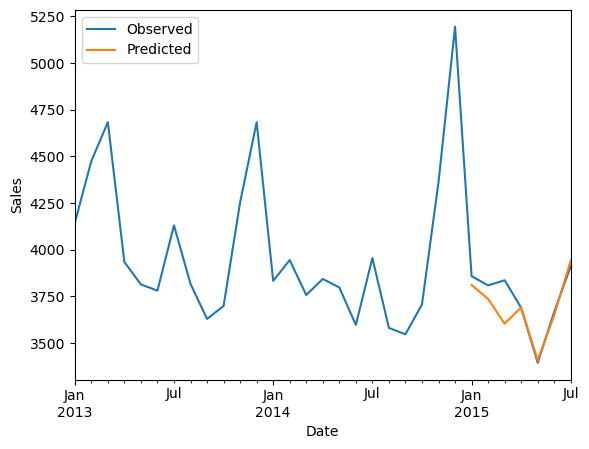

Date
2015-01-01    3810.685119
2015-02-01    3735.677654
2015-03-01    3603.200543
2015-04-01    3690.531725
2015-05-01    3406.861544
2015-06-01    3649.525342
2015-07-01    3942.534984
Freq: MS, Name: predicted_mean, dtype: float64
ye hai org Date
2015-01-01    3858.129032
2015-02-01    3808.392857
2015-03-01    3836.032258
2015-04-01    3688.500000
2015-05-01    3394.193548
2015-06-01    3667.033333
2015-07-01    3911.806452
Freq: MS, Name: Sales, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -17.415
Date:                            Sun, 10 Sep 2023   AIC                             48.830
Time:                                    16:19:08   BIC                             44.534
Sample:                                01-01-2013   HQIC                   

In [61]:
#Store Type C - example 2

or_c = (1,1,1)
sord_c=(0, 1, 1, 12)
result_c,mse_c,rmse_c,rmspe_c= predictions(y_sale_model_c,exog_c,or_c,sord_c)
print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_c, 2)))

In [69]:
#Store Type D - example 1

or_d = (0,3,0)
sord_d=(0, 3, 0, 12)
#result_d,mse_d,rmse_d,rmspe_d= predictions(y_sale_model_d,exog_d,or_d,sord_d)
#print(result_d.summary())
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse_d, 2)))
#print('The Root Squared Error of our forecasts is {}'.format(round(rmse_d, 2)))
#print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_d, 2)))

Implementing AUTO-ARIMA model                                                                                                   

In this auto arima model, we will train the model using the training data. The average sales for each month is taken as a sample value to be fed to the model and then on the basis of the data given, the model will generate the average sales value for the future month.

In [62]:
from pmdarima.arima import auto_arima

test['Date'] = pd.to_datetime(test['Date'], errors='coerce')
test.info()

def predict_sales_auto_arima(sales_data):
    # Fit the auto ARIMA model
    model = auto_arima(sales_data, start_p = 0, d = 1, start_q = 0, max_p = 3, max_d = 3, max_q = 3, start_P = 0, D = 1, start_Q = 0, max_P = 5, max_D = 2, max_Q = 5, m = 12, seasonal=True, trace=True, 
                       stepwise = True, random_state = 20, n_fits = 10)
    model.summary()

    # Create a DataFrame for the predicted sales
    forecast_periods = 12
    #predicted_sales = pd.DataFrame(model.predict(n_periods=forecast_periods), index=test_sales_a.index, columns=['Predicted_sales'])
    predicted_sales = pd.DataFrame(model.predict(n_periods=forecast_periods), columns=['Average Predicted Sales'])
    predicted_sales = predicted_sales.dropna()

    return predicted_sales


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41088 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [63]:
#predicting the future average sales value for the store type A
predictions = predict_sales_auto_arima(y_sale_model_a)
predictions = predictions.set_index(pd.to_datetime(predictions.index, format='%Y-%m').strftime("%Y-%m"))
predictions

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=254.940, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=253.966, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=252.176, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=253.961, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=250.308, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=251.995, Time=0.14 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=251.991, Time=0.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=253.989, Time=0.20 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=249.737, Time=0.07 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=251.734, Time=0.16 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=251.735, Time=0.16 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=in

,Average Predicted Sales
2015-08,3885.519377
2015-09,4407.967933
2015-10,4067.109624
2015-11,4457.112270
2015-12,5047.678498
2016-01,4229.303998
2016-02,4161.395900
2016-03,4403.841269
2016-04,4124.614918
2016-05,3821.848023


In [64]:
#working on the training dataset to make predictions, to compare it with the ground truth as we dont have ground truth in our test data set

# Specify the date to split on (e.g., '2023-01-01')
split_date = '2015-01-01'

# Create the training set (before the split date)
ar_train = train2[train2.index < split_date]

# Create the testing set (after or on the split date)
ar_test = train2[train2.index >= split_date]

ar_train.shape,ar_test.shape

((780829, 26), (236380, 26))

In [67]:
#Function for all 
def my_auto_arima(train_data ,test_data,n):
    
    #sampling of the train dataset by selecting a particular store id for a particular store type and 
    train_ar_a = train_data[train_data.Store == n]['Sales']
    sample_train_sale = sample(train_ar_a)
    sample_train_sale = pd.DataFrame(sample_train_sale)

    #sample_train_sale_a
    test_ar_a = test_data[test_data.Store == n]['Sales']
    sample_test_sale = sample(test_ar_a)
    sample_test_sale = pd.DataFrame(sample_test_sale)

    #fitting the model
    model = auto_arima(sample_train_sale, start_p = 0, d = 1, start_q = 0, max_p = 5, max_d = 2, max_q = 5, start_P = 0, D = 1, start_Q = 0, max_P = 5, max_D = 2, max_Q = 5, m = 12, seasonal=True, trace=True, 
                           stepwise = True, random_state = 20, n_fits = 10)
    model.summary()
    
    #predicting the sales value
    predicted_sales = pd.DataFrame(model.predict(n_periods=7), index=sample_test_sale.index, columns=['Predicted Average Monthly Sales'])
    predicted_sales['Actual Average Monthly Sales'] = sample_test_sale['Sales']
    
    
    #calculating the error values mse and rmse
    actual_values = predicted_sales['Actual Average Monthly Sales']
    predicted_values = predicted_sales['Predicted Average Monthly Sales']
    mse = np.mean((actual_values - predicted_values) ** 2)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)    
    return predicted_sales

In [68]:
my_auto_arima(ar_train,ar_test,3)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=169.169, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=169.981, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=170.871, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=170.848, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=172.781, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=171.118, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.257 seconds
Mean Squared Error (MSE): 103544.39803532176
Root Mean Squared Error (RMSE): 321.78315374693216


,Predicted Average Monthly Sales,Actual Average Monthly Sales
Date,,
2015-01-01,5523.225806,5412.741935
2015-02-01,5525.665899,5483.464286
2015-03-01,5537.290323,5704.354839
2015-04-01,5337.551613,5706.100000
2015-05-01,5183.548387,5298.193548
2015-06-01,5619.484946,6330.600000
2015-07-01,5752.387097,5920.483871


In [ ]:
my_auto_arima(ar_train,ar_test,85)